In [3]:
#v3.classification
#28/11/2018

dataname="lymphoma"
gpuid=0

patch_size=224 #should match the value used to train the network
batch_size=1 #nicer to have a single batch so that we can iterately view the output, while not consuming too much 
nprint = 2 # number of results to show 

In [5]:
# https://github.com/jvanvugt/pytorch-unet
#torch.multiprocessing.set_start_method("fork")
import random, sys
import cv2
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.ndimage
import time

import tables
from sklearn.metrics import confusion_matrix
from tensorboardX import SummaryWriter

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import DenseNet

import PIL



In [6]:
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='TITAN X (Pascal)', major=6, minor=1, total_memory=12189MB, multi_processor_count=28)


In [13]:
checkpoint = torch.load(f"{dataname}_densenet_best_model.pth")

In [14]:
#load the model, note that the paramters are coming from the checkpoint, since the architecture of the model needs to exactly match the weights saved

model = DenseNet(growth_rate=checkpoint["growth_rate"], block_config=checkpoint["block_config"],
                 num_init_features=checkpoint["num_init_features"], bn_size=checkpoint["bn_size"], drop_rate=checkpoint["drop_rate"], num_classes=checkpoint["num_classes"]).to(device)

print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")
model.load_state_dict(checkpoint["model_dict"])

total params: 	415683


In [15]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname

        self.img_transform=img_transform
        
        self.tables=tables.open_file(self.fname)
        self.classsizes=self.tables.root.classsizes[:]
        self.nitems=self.tables.root.imgs.shape[0]
        self.tables.close()
        
        self.imgs = None
        self.labels = None
        
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here
        if(self.imgs is None): #open in thread
            self.tables=tables.open_file(self.fname)
            self.imgs=self.tables.root.imgs
            self.labels=self.tables.root.labels
       
        #get the requested image and mask from the pytable
        img = self.imgs[index,:,:,:]
        label = self.labels[index]
        
        img_new = img
        
        if self.img_transform is not None:
            img_new = self.img_transform(img)


        return img_new, label, img
    def __len__(self):
        return self.nitems

In [18]:
#probably only want to crop data to right size and otherwise not alter data during validation process
img_transform = transforms.Compose([
     transforms.ToPILImage(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), 
#     transforms.RandomResizedCrop(size=patch_size),
#     transforms.RandomRotation(180),
#     transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=.5),
#     transforms.RandomGrayscale(),
    transforms.ToTensor()
    ])

phases=["val"]
dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase]=Dataset(f"./{dataname}_{phase}.pytable", img_transform=img_transform)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0, pin_memory=True) 



[-2.7184715 -5.260073   3.5114665]
True class:		2
Predicted class:	2
--------
[-2.9445949  2.5575895 -3.210987 ]
True class:		1
Predicted class:	1
--------
[-8.008348  -1.8226794  3.9745553]
True class:		2
Predicted class:	2
--------
[-1.4196036 -6.8790374  3.0786932]
True class:		2
Predicted class:	2
--------
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 3.]]
Accuracty:	1.0


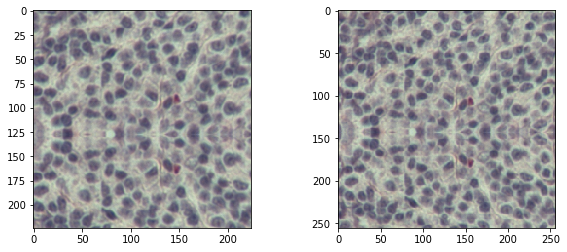

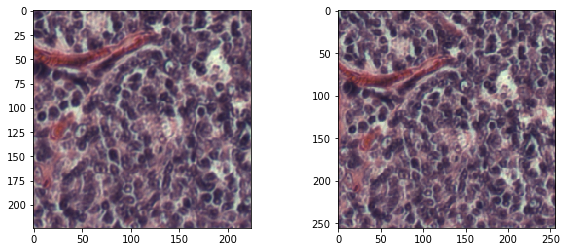

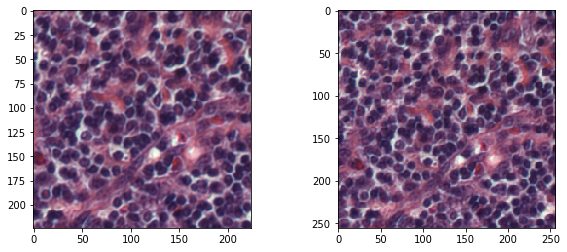

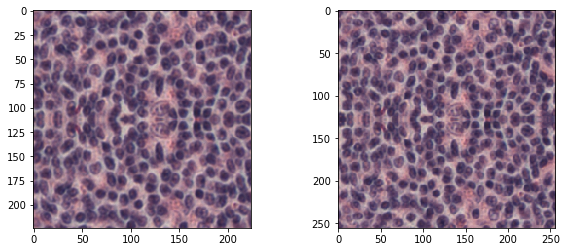

In [32]:
%matplotlib inline

#set the model to evaluation mode, since we're only generating output and not doing any back propogation
model.eval()
confmatrix=np.zeros((checkpoint["num_classes"],checkpoint["num_classes"]))
for ii , (X, label, img_orig) in enumerate(dataLoader['val']): #for each of the batches
    X = X.to(device)  # [NBATCH, 3, H, W]
    label = label.type('torch.LongTensor').to(device)  # [Nbatch, H, W] with class indices (0, 1)

    output = model(X)  # [NBATCH, 2, H, W]

    output=output.detach().squeeze().cpu().numpy() #get output and pull it to CPU
    
    print(output)
    gt=label.cpu()[0]
    pred=np.argmax(output)
    confmatrix[gt,pred]+=1
    print(f"True class:\t\t{gt}")
    print(f"Predicted class:\t{pred}")
    print("--------")
#--- to visualize, uncomment here
    fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
    ax[0].imshow(np.moveaxis(X.detach().squeeze().cpu().numpy(),0,-1))
    ax[1].imshow(img_orig.cpu().squeeze())

#--- to limit the number of output, uncomment here
    if(ii>nprint):
        break
        
print(confmatrix)
print(f"Accuracty:\t{confmatrix.trace()/confmatrix.sum()}")